<a href="https://colab.research.google.com/github/ebudd45/Meteorologyclass/blob/main/surfacedata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Magic to make Cartopy work-takes a few minutes 
!pip install cartopy
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install -q -c conda-forge cartopy
import cartopy
cartopy.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
✨🍰✨ Everything looks OK!


/usr/local/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


'0.21.1'

In [2]:
#Install needed modules
!pip install metpy
!pip install cartopy
!pip install siphon
!pip install netcdf4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.8/387.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.5/269.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.2/981.2 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 27.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.2/132.2 

In [18]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage

from cftime import num2date
from metpy.units import units
from siphon.catalog import TDSCatalog

In [4]:
# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

In [5]:
# Specify our date/time of product desired
dt = datetime(2018, 1, 4, 12)

# Construct the URL for our THREDDS Data Server Catalog,
# and access our desired dataset within via NCSS
base_url = 'https://www.ncei.noaa.gov/thredds/model-gfs-g4-anl-files-old/'
cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')
ncss = cat.datasets[f'gfsanl_4_{dt:%Y%m%d}_{dt:%H}00_000.grb2'].subset()

# Create our NCSS query with desired specifications
query = ncss.query()
query.time(dt)
query.lonlat_box(north=65, south=15, east=310, west=220)
query.accept('netcdf')
query.variables('Pressure_reduced_to_MSL_msl',
                'Apparent_temperature_height_above_ground',
                'u-component_of_wind_height_above_ground',
                'v-component_of_wind_height_above_ground')

# Obtain the data we've queried for
data = ncss.get_data(query)

In [16]:
print(data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Originating_or_generating_Center: US National Weather Service, National Centres for Environmental Prediction (NCEP)
    Originating_or_generating_Subcenter: 0
    GRIB_table_version: 2,1
    Type_of_generating_process: Forecast
    Analysis_or_forecast_generating_process_identifier_defined_by_originating_centre: Analysis from GFS (Global Forecast System)
    Conventions: CF-1.6
    history: Read using CDM IOSP GribCollection v3
    featureType: GRID
    History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)
Original Dataset = /san5302/nexus/gfsanl/201801/20180104/gfsanl_4_20180104_1200_000.grb2; Translation Date = 2023-03-23T22:23:20.927Z
    geospatial_lat_min: 15.0
    geospatial_lat_max: 65.0
    geospatial_lon_min: -140.0
    geospatial_lon_max: -50.0
    dimensions(sizes): time(1), lat(101), lon(181), height_above_ground(1), height_above_ground3(3)
    variabl

In [6]:
# Pull out variables you want to use
mslp = data.variables['Pressure_reduced_to_MSL_msl'][:].squeeze()
temp = units.K * data.variables['Apparent_temperature_height_above_ground'][:].squeeze()
u_wind = units('m/s') * data.variables['u-component_of_wind_height_above_ground'][:].squeeze()
v_wind = units('m/s') * data.variables['v-component_of_wind_height_above_ground'][:].squeeze()
lat = data.variables['lat'][:].squeeze()
lon = data.variables['lon'][:].squeeze()
time_var = data.variables[find_time_var(data.variables['Pressure_reduced_to_MSL_msl'])]

# Convert winds to knots
u_wind.ito('kt')
v_wind.ito('kt')

# Convert number of hours since the reference time into an actual date
time = num2pydate(time_var[:].squeeze(), time_var.units)

lev_10m = np.where(data.variables['height_above_ground3'][:] == 10)[0][0]
u_wind_10m = u_wind[lev_10m]
v_wind_10m = v_wind[lev_10m]

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Smooth MSLP a little
# Be sure to only put in a 2D lat/lon or Y/X array for smoothing
smooth_mslp = ndimage.gaussian_filter(mslp, sigma=3, order=0) * units.Pa
smooth_mslp.ito('hPa')

In [19]:
#Extract time
time = data.variables['time']
print(time.units)
vtime = num2date(time[0], units=time.units)
print(vtime)

Hour since 2018-01-04T12:00:00Z
2018-01-04 12:00:00


In [10]:
# Data projection; NARR Data is Earth Relative
dataproj = ccrs.PlateCarree()

# Plot projection
# The look you want for the view, LambertConformal for mid-latitude view
plotproj = ccrs.LambertConformal(central_longitude=-100., central_latitude=40.,
                                 standard_parallels=[30, 60])

In [11]:
def create_map_background():
    fig=plt.figure(figsize=(14, 12))
    ax=plt.subplot(111, projection=plotproj)
    ax.set_extent([-125, -73, 25, 50],ccrs.PlateCarree())
    ax.coastlines('50m', linewidth=0.75)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    return fig, ax

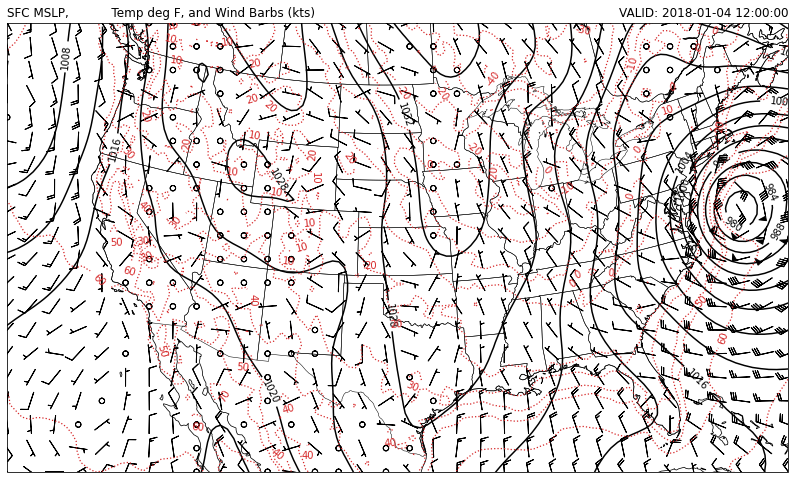

In [20]:
fig, ax = create_map_background()

# Plot MSLP Contours
clev_mslp = np.arange(0, 1200, 4)
cs = ax.contour(lon_2d, lat_2d, smooth_mslp, clev_mslp, colors='black', linewidths=1.5,
                linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot 2m Temperature Contours
clevtemp = np.arange(-60, 101, 10)
cs2 = ax.contour(lon_2d, lat_2d, temp.to(units('degF')), clevtemp,
                 colors='tab:red', linewidths=1.25, linestyles='dotted',
                 transform=datacrs)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot 10m Wind Barbs
ax.barbs(lon_2d, lat_2d, u_wind_10m.magnitude, v_wind_10m.magnitude,
         length=6, regrid_shape=20, pivot='middle', transform=datacrs)

# Titles
plt.title('SFC MSLP, \
          Temp deg F, and Wind Barbs (kts)', loc='left')
plt.title(f'VALID: {vtime}', loc='right')

plt.show()